In [1]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import sys, os, yaml
import pickle
import inspect


def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]
sys.path.append("/home/")
fig_folder = os.path.join(os.sep, "home", "smoke", "artifacts")
import tqdm
run_id_yaml = "artifacts/mlflow_run_id.yaml"
run_id = "a5fc860be53d48c9ac1573b75f1cba8f"

In [2]:
def bmm(a, b):
    return np.einsum("Bij,Bjk ->Bik", a, b)


def bt(a):
    return np.einsum("Bij->Bji", a)


def bouter(a, b):
    return np.einsum("Bnr,Bnr -> Bnn", a, b)


def bouter1D(a, b):
    return np.einsum("Bi,Bj -> Bij", a, b)


def bqr(a):
    Q = np.empty_like(a)
    for i, mat in enumerate(a):
        Q[i, ...] = np.linalg.qr(mat)[0]
    return Q

def printshape(*args):
    for el in args:
        try:
            print(f"{retrieve_name(el)}.shape={el.shape}")
        except e:
            pass

In [8]:
A_ = np.random.normal(size = (5, 20, 20))
A = bmm(bt(A_), A_)
np.linalg.slogdet(A)

(array([1., 1., 1., 1., 1.]),
 array([32.93963796, 46.79827229, 28.962569  , 35.91818515, 38.01183152]))

In [21]:
weights_, vectors_ = np.linalg.eigh(A)
weights, vectors = weights_[:, :]+1.0, vectors_[:, :, :]

In [25]:
weights.shape, vectors.shape
np.isclose((A - bmm(vectors, weights[:, :, None] * bt(vectors))), 0).all()

True

In [39]:
def low_rank_construction(Ur, Sr):
    return bmm(Ur, Sr[:, :, None] * bt(Ur))

def identity_batch(state_dimension, nbatch):
    return np.tile(np.eye(state_dimension), (nbatch, 1, 1))

id_batch = identity_batch(5, 3)

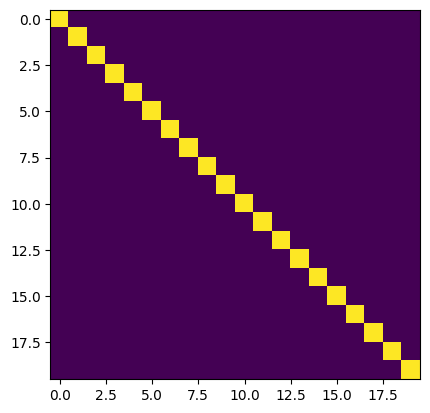

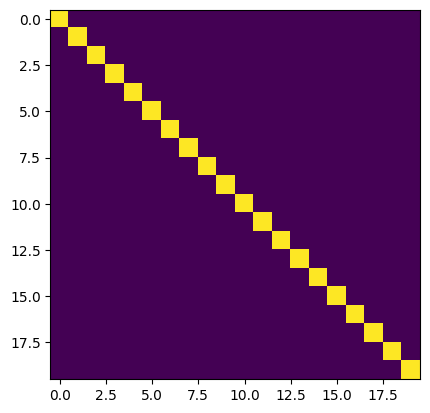

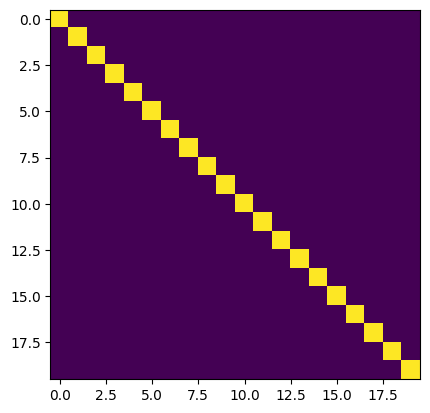

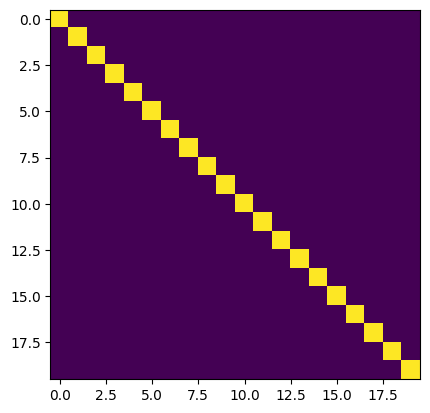

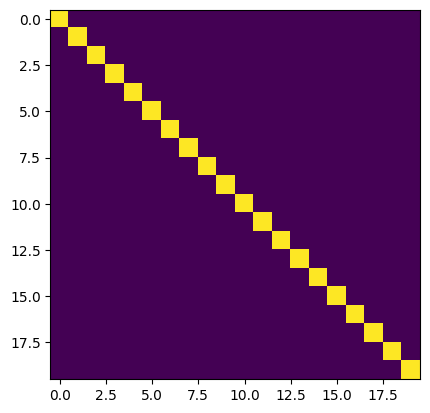

In [46]:

def power_singular_value_reconstructon(Ur, Sr, alpha):
    batch_size, state_dimension, rk = Ur.shape
    identity = identity_batch(state_dimension, batch_size)
    return identity + low_rank_construction(Ur, Sr ** (alpha) - 1)


low_rank_construction(vectors, weights)

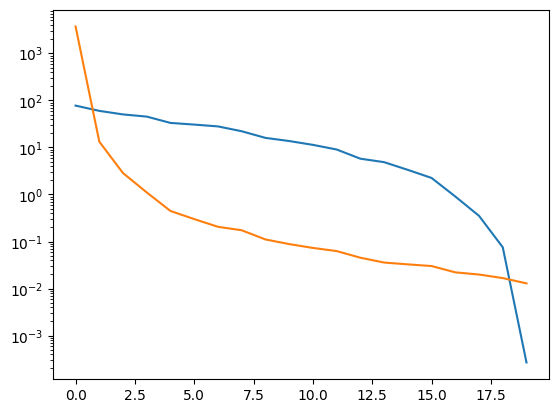

In [51]:
plt.plot(np.linalg.svd(power_singular_value_reconstructon(vectors, weights, 1)[0], compute_uv=False))
plt.plot(np.linalg.svd(power_singular_value_reconstructon(vectors, weights, -1)[0], compute_uv=False))
plt.yscale('log')

In [8]:
with open(run_id_yaml, "r") as fstream:
    run_id_yaml = yaml.safe_load(fstream)
    # run_id = run_id_yaml["run_id"]
    data_path = run_id_yaml["data_path"]

In [9]:
logged_model = f"runs:/{run_id}/smoke_model"
# mlflow.pyfunc.get_model_dependencies(logged_model)
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(f"{loaded_model=}")


loaded_model=mlflow.pyfunc.loaded_model:
  artifact_path: smoke_model
  flavor: mlflow.pytorch
  run_id: a5fc860be53d48c9ac1573b75f1cba8f



In [10]:
with open(data_path, "rb") as handle:
    data = pickle.load(handle)
x_, fo_, tlm_ = zip(*data)

x_ = np.asarray(x_)

In [11]:
def construct_svd_ML(loaded_model, x_):
    pred = loaded_model.predict(np.asarray(x_).astype("f"))
    Ur, logsvals = pred[:, :-1, :], pred[:, -1, :]
    Sr = np.exp(logsvals)
    Ur = bqr(Ur)
    # proj = bmm(qi, (inv_sv[..., None] * bt(qi)))
    return Sr.squeeze(), Ur.squeeze()


In [12]:
svds = construct_svd_ML(loaded_model, x_)

In [13]:
tlm_[0].shape

(1000, 100)

In [14]:
Sr = svds[0]
Ur = svds[1]

In [15]:
idx = 0
U_ex = Ur[idx, ...]
S_ex = Sr[idx]
A_t = tlm_[idx].T @ tlm_[idx]
A_re = U_ex @ (S_ex * U_ex).T
U_t, S_t, _ = np.linalg.svd(A_t) #U_t @ (S_t * U_t).T == A_t
printshape(U_ex, S_ex, A_t, A_re, U_t, S_t)
pinv_re = U_ex @ (S_ex**(-1) * U_ex).T

def construct_regul_thik(U, S, alpha=0.0):
    return U @ ((S / (S**2  + alpha )) * U).T

U_ex.shape=(100, 75)
S_ex.shape=(75,)
A_t.shape=(100, 100)
A_re.shape=(100, 100)
U_t.shape=(100, 100)
S_t.shape=(100,)


19.016934962905733
9.646340926607527
5.552778657936321


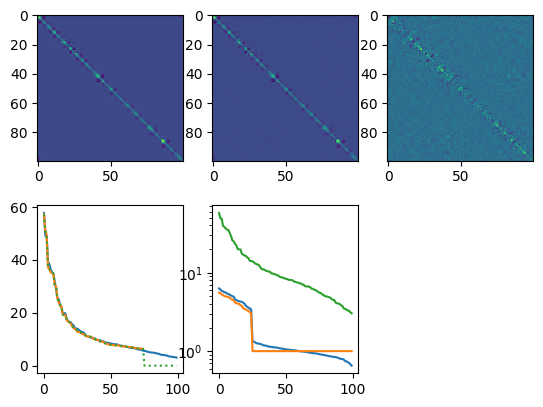

In [16]:
plt.subplot(2, 3, 1)
plt.imshow(A_t)
plt.subplot(2, 3, 2)
plt.imshow(A_re)
plt.subplot(2, 3, 3)
plt.imshow(A_t - A_re)
plt.subplot(2, 3, 4)
plt.plot(np.linalg.svd(A_t, compute_uv=False))
plt.plot(np.sort(S_ex)[::-1])
plt.plot(np.linalg.svd(A_re, compute_uv=False), ':')
plt.subplot(2, 3, 5)
plt.plot(np.linalg.svd((np.eye(100) + U_ex @ ((S_ex**(-1) - 1) * U_ex).T) @ A_t, compute_uv=False))
plt.plot(np.linalg.svd((np.eye(100) + U_t[..., :75] @ ((S_t[..., :75]**(-1) - 1) * U_t[..., :75]).T) @ A_t, compute_uv=False))
plt.plot(np.linalg.svd(A_t, compute_uv=False))
plt.yscale("log")
prec_A = (np.eye(100) + U_ex @ ((S_ex**(-1) - 1) * U_ex).T) @ A_t
prec_A_t = (np.eye(100) + U_t[..., :75] @ ((S_t[..., :75]**(-1) - 1) * U_t[..., :75]).T) @ A_t
print(np.linalg.cond(A_t))
print(np.linalg.cond(prec_A))
print(np.linalg.cond(prec_A_t))

In [17]:
sort_idx = np.argsort(S_ex)[::-1]
U_ex = U_ex[:, sort_idx]


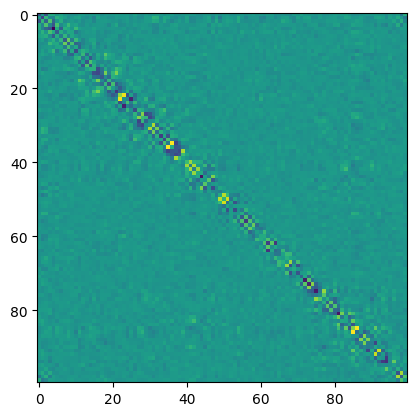

In [18]:
plt.imshow(A_t @ pinv_re @ A_t - A_t)


In [31]:
def inverse_iteration(A, b0, mu):
    def_A = A - mu * np.eye(A.shape[0])
    b1 = np.linalg.solve(def_A, b0)
    return b1 / np.linalg.norm(b1)

def inverse_iteration_alg(A, b0, mu, niters=5):
    b_new = b0
    for i in range(niters):
        b_new = inverse_iteration(A, b_new, mu)
    return b_new

In [32]:
new_U = inverse_iteration_alg(A_t, U_ex[..., 0], S_ex[0], 2)

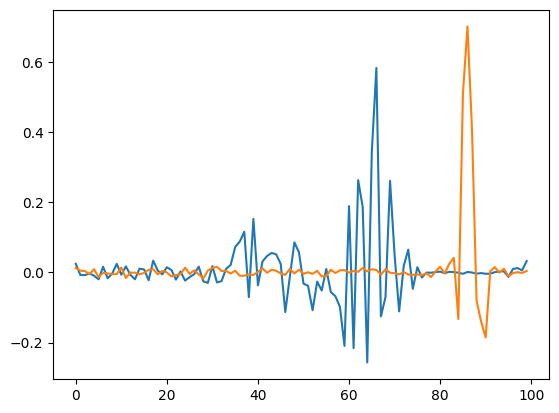

In [33]:
plt.plot(new_U)
plt.plot(U_ex[..., 0])

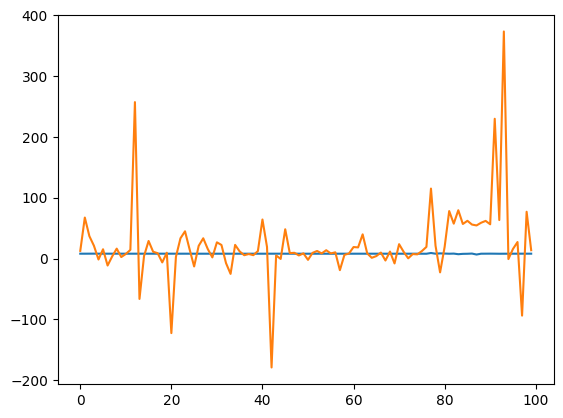

In [34]:
plt.plot((A_t @ new_U) / new_U)
plt.plot((A_t @ U_ex[..., 0]) / U_ex[..., 0])

In [35]:
from DA_PoC.common.linalg import randomised_eigval_decomposition


In [83]:
W, V = randomised_eigval_decomposition(A_t, 75, 2)
print(W.shape, V.shape)

(75,) (100, 75)


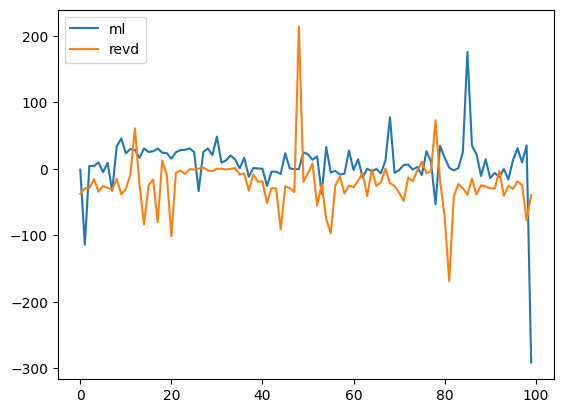

In [84]:
idx = 5
plt.plot((A_t @ U_ex[:, idx] / U_ex[:, idx]) - S_ex[idx], label='ml')
plt.plot((A_t @ V[:, idx] / V[:, idx]) - W[idx], label='revd')
plt.legend()


In [85]:
err = []
for idx in range(75):
    err_ml = np.mean(((A_t @ U_ex[:, idx] / U_ex[:, idx]) - S_ex[idx])**2)
    err_revd = np.mean(((A_t @ V[:, idx] / V[:, idx]) - W[idx])**2)
    err.append((err_ml, err_revd))

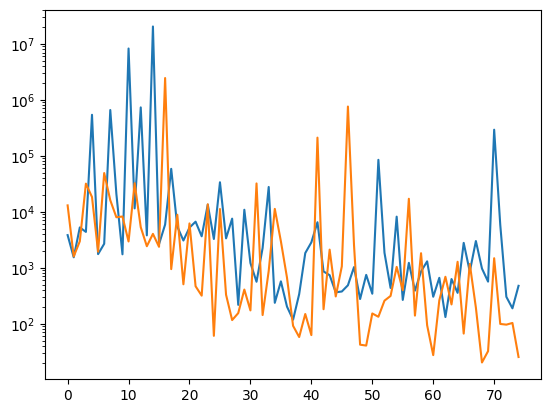

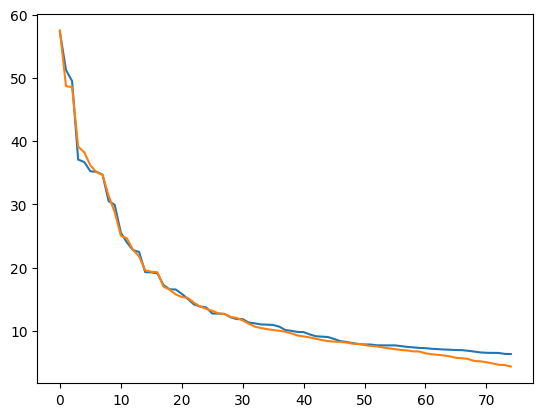

In [86]:
e_ml, e_revd = zip(*err)
plt.plot(e_ml, label='ml')
plt.plot(e_revd, label='revd')
plt.yscale('log')
plt.figure()
plt.plot(np.sort(S_ex)[::-1])
plt.plot(W)